## Import & Data Load

In [1]:
# CatBoost 모델 특징
# 특징1.  CatBoost는 카테고리 특성을 자동으로 처리하는 기능
# 특징2. 대용량 데이터셋에서도 잘 작동함
# 특징3. CatBoost는 기본적으로 대칭 트리를 사용하여 과적합을 줄이는 데 도움
# 특징4. CatBoost는 미세 조정 없이도 좋은 성능을 내는 경향이 있음. 하이퍼파라미터 튜닝에 대한 노력을 덜 해도 괜찮음

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import catboost


train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

## Data Pre-processing

In [23]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])


# datetime을 여러 파생 변수로 변환
train['year'] = train['ATA'].dt.year
train['month'] = train['ATA'].dt.month
train['day'] = train['ATA'].dt.day
train['hour'] = train['ATA'].dt.hour
train['minute'] = train['ATA'].dt.minute
train['weekday'] = train['ATA'].dt.weekday


# datetime을 여러 파생 변수로 변환
test['year'] = test['ATA'].dt.year
test['month'] = test['ATA'].dt.month
test['day'] = test['ATA'].dt.day
test['hour'] = test['ATA'].dt.hour
test['minute'] = test['ATA'].dt.minute
test['weekday'] = test['ATA'].dt.weekday

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

<ipython-input-23-ab4d3422c734>:24: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  train.fillna(train.mean(), inplace=True)
<ipython-input-23-ab4d3422c734>:24: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.fillna(train.mean(), inplace=True)
<ipython-input-23-ab4d3422c734>:25: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  test.fillna(train.mean(), inplace=True)
<ipython-input-23-ab4d3422c734>:25: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_on

In [24]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

## 모델 학습 및 특성 중요도 확인

Model Tune for CatBoost.
Learning rate set to 0.104107
0:	learn: 167.7585837	total: 399ms	remaining: 6m 38s
1:	learn: 165.4901416	total: 781ms	remaining: 6m 29s
2:	learn: 163.6160477	total: 1.16s	remaining: 6m 25s
3:	learn: 162.1116869	total: 1.48s	remaining: 6m 8s
4:	learn: 160.8348389	total: 1.79s	remaining: 5m 56s
5:	learn: 159.5962879	total: 2.11s	remaining: 5m 49s
6:	learn: 158.6894335	total: 2.59s	remaining: 6m 8s
7:	learn: 157.8217598	total: 3.29s	remaining: 6m 48s
8:	learn: 157.1306995	total: 4.16s	remaining: 7m 37s
9:	learn: 156.4166064	total: 4.8s	remaining: 7m 55s
10:	learn: 155.8744446	total: 5.2s	remaining: 7m 47s
11:	learn: 155.4437833	total: 5.65s	remaining: 7m 45s
12:	learn: 155.0198952	total: 6.02s	remaining: 7m 37s
13:	learn: 154.6445459	total: 6.44s	remaining: 7m 33s
14:	learn: 154.2892311	total: 6.9s	remaining: 7m 33s
15:	learn: 153.9686129	total: 7.87s	remaining: 8m 4s
16:	learn: 153.6390066	total: 8.27s	remaining: 7m 58s
17:	learn: 153.3819293	total: 8.69s	remaini

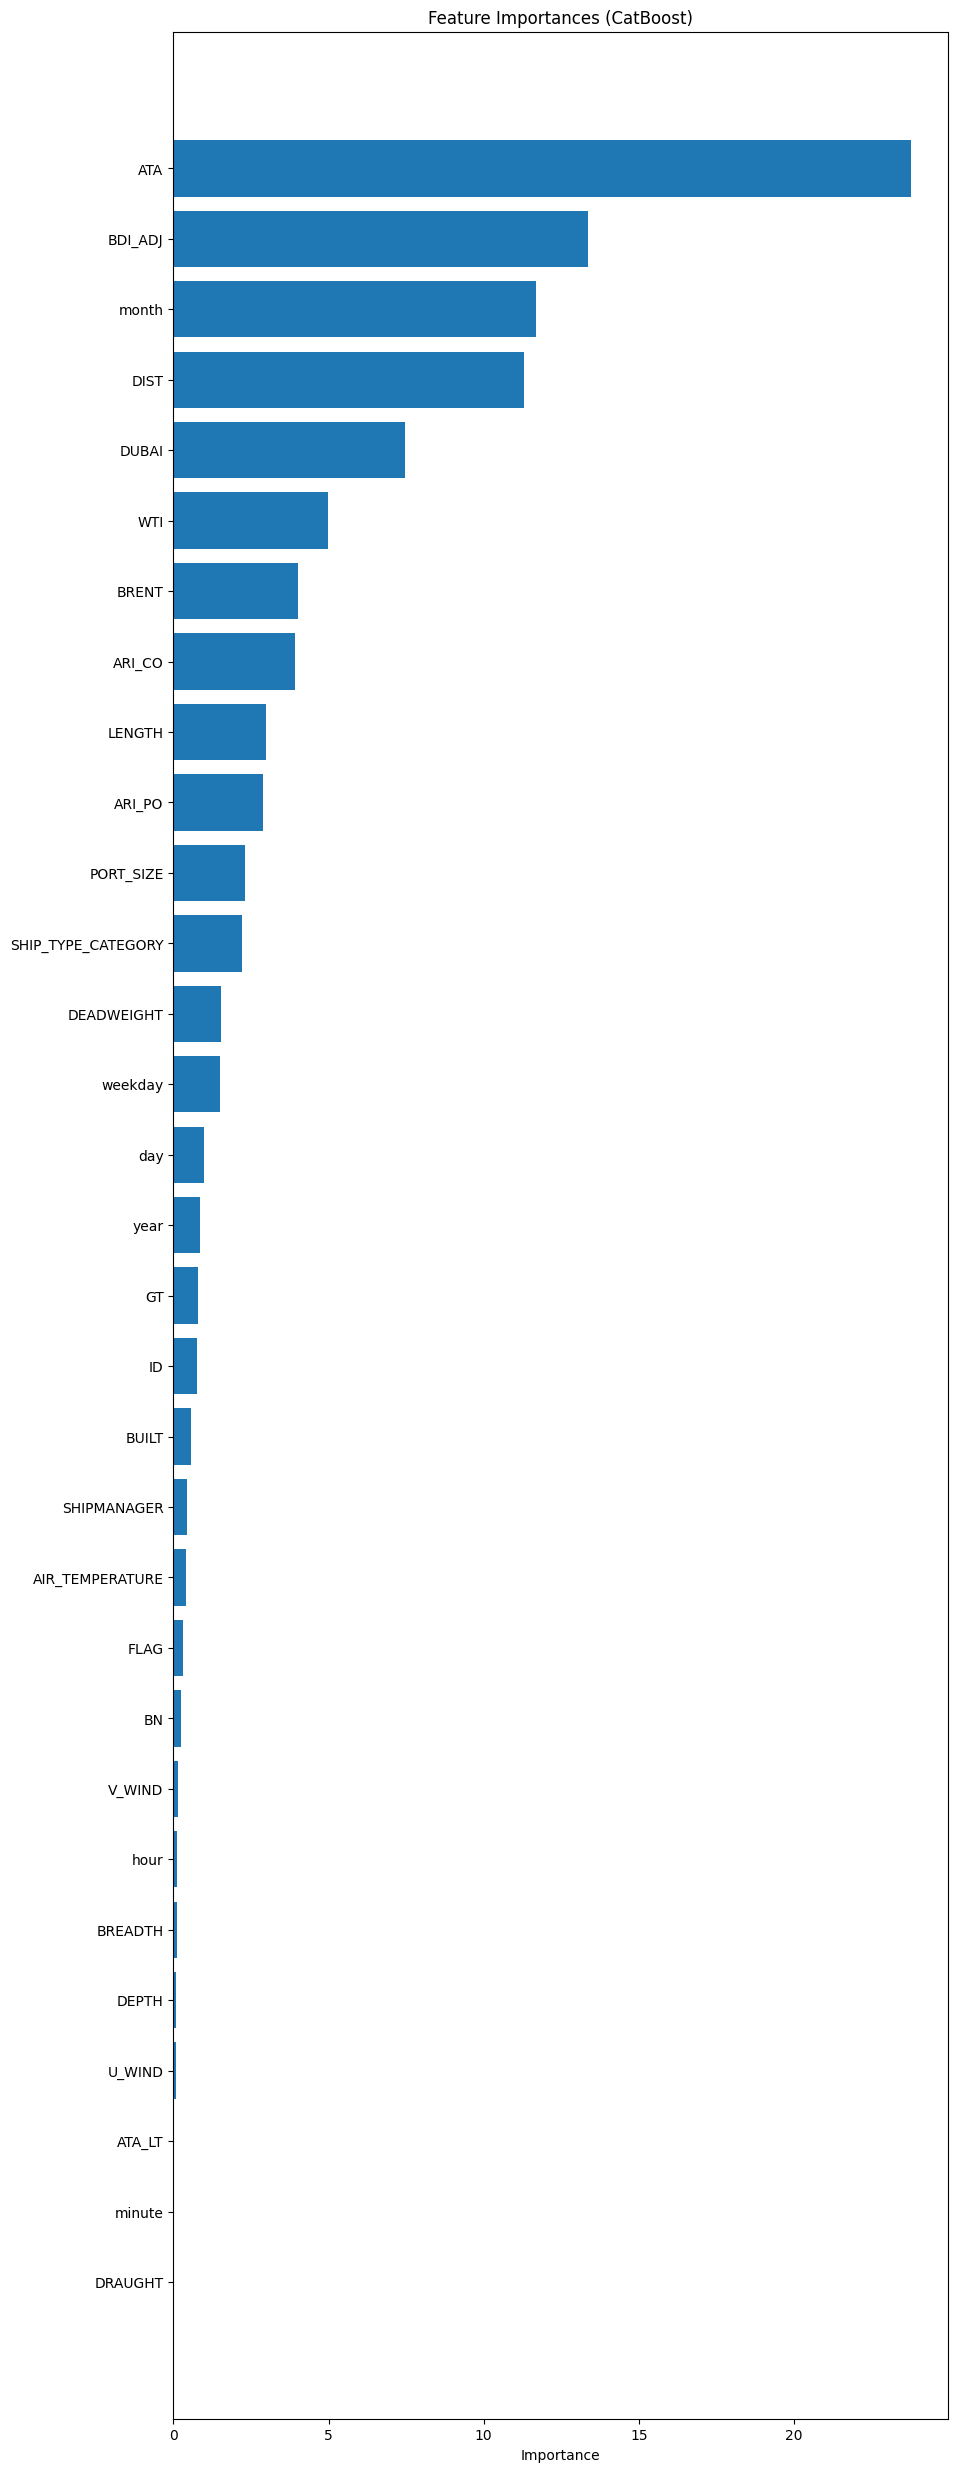

In [25]:
import catboost
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

def train_and_evaluate(model, model_name, X_train, y_train, cat_features=None):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train, cat_features=cat_features)

    feature_importances = model.get_feature_importance()
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# 카테고리형 특성의 인덱스를 지정합니다.
cat_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
# CatBoost 모델로 변경
catboost_model = CatBoostRegressor()
catboost_model, catboost_feature_importances = train_and_evaluate(catboost_model, 'CatBoost', X_train, y_train, cat_features)


월별 차이가 없는데도 불구하고 특성 중요도가 제일 높게 나옴
# **>> 추가로 계절이라는 열을 추가함**

In [7]:
train['month'].value_counts()

1     32838
7     31760
6     31600
5     31424
2     31251
8     30724
11    30249
3     30071
12    30024
9     29655
10    29169
4     28676
Name: month, dtype: int64

In [26]:
# train_plus_one 데이터프레임 생성 계절 추가본임
train_plus_one = train.copy()
test_plus_one = test.copy()

In [27]:
train_plus_one['weather'] = None
test_plus_one['weather'] = None

In [10]:
# month 데이터 타입 확인
type(train['month'][0])

numpy.int64

In [28]:
for i in range(len(train)):
  if train_plus_one['month'][i] in [3,4,5]:
    train_plus_one['weather'][i] = 'spring'
  elif train_plus_one['month'][i] in [6,7,8]:
    train_plus_one['weather'][i] = 'summer'
  elif train_plus_one['month'][i] in [9,10,11]:
    train_plus_one['weather'][i] = 'fall'
  else:
    train_plus_one['weather'][i] = 'winter'


for i in range(len(test)):
  if test_plus_one['month'][i] in [3,4,5]:
    test_plus_one['weather'][i] = 'spring'
  elif test_plus_one['month'][i] in [6,7,8]:
    test_plus_one['weather'][i] = 'summer'
  elif test_plus_one['month'][i] in [9,10,11]:
    test_plus_one['weather'][i] = 'fall'
  else:
    test_plus_one['weather'][i] = 'winter'

<ipython-input-28-403a810f031b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_plus_one['weather'][i] = 'fall'
<ipython-input-28-403a810f031b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_plus_one['weather'][i] = 'winter'
<ipython-input-28-403a810f031b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_plus_one['weather'][i] = 'summer'
<ipython-input-28-403a810f031b>:3: SettingWithCopyWarning: 
A value is trying 

# **두번째 새로운 열 추가 **

시간순으로 나열 해 본 결과

In [30]:
train_plus_one = train_plus_one.sort_values(by='ATA')
test_plus_one = test_plus_one.sort_values(by='ATA')
train_plus_one.head(30)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday,weather
122375,BR,VFD8,Bulk,0.000000,2014-09-01 00:05:00,S736157,30.0,22,50300,20.0,...,1137.632567,0.000061,0.000000,2014,9,1,0,5,0,fall
56102,ZA,CXL1,Bulk,49.910085,2014-09-01 00:05:00,A876246,40.0,12,175000,20.0,...,1128.737090,0.000026,48.778889,2014,9,1,0,5,0,fall
361769,ZA,CXL1,Bulk,0.000000,2014-09-01 00:05:00,I488233,40.0,12,181000,20.0,...,1137.632567,0.000026,0.000000,2014,9,1,0,5,0,fall
37691,BR,MMW5,Bulk,32.304726,2014-09-01 00:12:00,G218822,30.0,13,56800,20.0,...,1167.284154,0.000051,265.620556,2014,9,1,0,12,0,fall
342710,BR,VFD8,Bulk,0.000000,2014-09-01 00:14:00,S763672,30.0,14,76600,20.0,...,1137.632567,0.000061,0.000000,2014,9,1,0,14,0,fall
277156,BR,TMW2,Bulk,28.638102,2014-09-01 00:16:00,L113748,40.0,13,180000,20.0,...,1183.098334,0.000080,227.623611,2014,9,1,0,16,0,fall
312523,BR,TMW2,Bulk,30.931174,2014-09-01 00:17:00,N841417,30.0,13,55700,20.0,...,1025.944921,0.000080,589.992500,2014,9,1,0,17,0,fall
194949,BR,TMW2,Bulk,24.744443,2014-09-01 00:18:00,R764154,30.0,12,38200,20.0,...,1076.352619,0.000080,412.149444,2014,9,1,0,18,0,fall
128234,RU,HGH2,Bulk,0.000000,2014-09-01 00:27:00,O124735,40.0,39,81000,20.0,...,1137.632567,0.000069,0.000000,2014,9,1,0,27,0,fall
249831,CA,PUF3,Bulk,0.000000,2014-09-01 00:27:00,D232875,20.0,50,30000,10.0,...,1137.632567,0.000107,0.000000,2014,9,1,0,27,0,fall


In [31]:
# 'ATA' 열에서 날짜 정보와 시간 정보를 추출
train_plus_one['Date'] = train_plus_one['ATA'].dt.date
train_plus_one['Time'] = train_plus_one['ATA'].dt.time

test_plus_one['Date'] = test_plus_one['ATA'].dt.date
test_plus_one['Time'] = test_plus_one['ATA'].dt.time

# 항구별로 그룹화하여 날짜-시간별로 누적값 계산
# 만약 2014년 9월 1일에 배가 총 3개 들어왔다면 시간 순서에 따라 1,2,3 값이 주어짐
train_plus_one['number'] = train_plus_one.groupby(['ARI_PO', 'Date', 'Time']).cumcount() + 1
test_plus_one['number'] = test_plus_one.groupby(['ARI_PO', 'Date', 'Time']).cumcount() + 1

In [32]:
train_plus_one

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,year,month,day,hour,minute,weekday,weather,Date,Time,number
122375,BR,VFD8,Bulk,0.000000,2014-09-01 00:05:00,S736157,30.0,22,50300,20.0,...,2014,9,1,0,5,0,fall,2014-09-01,00:05:00,1
56102,ZA,CXL1,Bulk,49.910085,2014-09-01 00:05:00,A876246,40.0,12,175000,20.0,...,2014,9,1,0,5,0,fall,2014-09-01,00:05:00,1
361769,ZA,CXL1,Bulk,0.000000,2014-09-01 00:05:00,I488233,40.0,12,181000,20.0,...,2014,9,1,0,5,0,fall,2014-09-01,00:05:00,2
37691,BR,MMW5,Bulk,32.304726,2014-09-01 00:12:00,G218822,30.0,13,56800,20.0,...,2014,9,1,0,12,0,fall,2014-09-01,00:12:00,1
342710,BR,VFD8,Bulk,0.000000,2014-09-01 00:14:00,S763672,30.0,14,76600,20.0,...,2014,9,1,0,14,0,fall,2014-09-01,00:14:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362429,TW,JWI3,Bulk,0.000000,2023-02-28 14:05:00,T131133,30.0,7,34500,10.0,...,2023,2,28,14,5,1,winter,2023-02-28,14:05:00,1
30182,AU,AIB7,Bulk,0.000000,2023-02-28 14:36:00,B744186,40.0,12,92100,20.0,...,2023,2,28,14,36,1,winter,2023-02-28,14:36:00,1
113951,CN,NCU8,Bulk,0.000000,2023-02-28 14:48:00,Q773567,30.0,10,82900,20.0,...,2023,2,28,14,48,1,winter,2023-02-28,14:48:00,1
340395,CN,NGG6,Container,0.000000,2023-02-28 14:51:00,U833772,30.0,29,22400,10.0,...,2023,2,28,14,51,1,winter,2023-02-28,14:51:00,1


In [15]:
train_plus_one['number'].describe()

count    367441.000000
mean          1.016931
std           0.233570
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          29.000000
Name: number, dtype: float64

# **새로운 열 2개의 특성 중요도 확인**

In [33]:
train_plus_one.drop(columns='ATA', inplace=True)
test_plus_one.drop(columns='ATA', inplace=True)

In [34]:
train_plus_one.drop(columns='Date', inplace=True)
test_plus_one.drop(columns='Date', inplace=True)

In [35]:
train_plus_one.drop(columns='Time', inplace=True)
test_plus_one.drop(columns='Time', inplace=True)

Model Tune for CatBoost.
Learning rate set to 0.104107
0:	learn: 167.8366827	total: 439ms	remaining: 7m 18s
1:	learn: 165.4875921	total: 739ms	remaining: 6m 8s
2:	learn: 163.5594357	total: 1.23s	remaining: 6m 49s
3:	learn: 161.9698412	total: 1.56s	remaining: 6m 28s
4:	learn: 160.6797097	total: 2.01s	remaining: 6m 40s
5:	learn: 159.5321464	total: 2.47s	remaining: 6m 49s
6:	learn: 158.6711897	total: 2.91s	remaining: 6m 52s
7:	learn: 157.7613713	total: 3.37s	remaining: 6m 57s
8:	learn: 157.0574107	total: 3.77s	remaining: 6m 55s
9:	learn: 156.4868806	total: 4.14s	remaining: 6m 50s
10:	learn: 156.0002366	total: 4.58s	remaining: 6m 51s
11:	learn: 155.5369129	total: 4.97s	remaining: 6m 49s
12:	learn: 155.1364839	total: 5.37s	remaining: 6m 47s
13:	learn: 154.8018169	total: 5.93s	remaining: 6m 57s
14:	learn: 154.4372879	total: 6.42s	remaining: 7m 1s
15:	learn: 154.0769268	total: 6.93s	remaining: 7m 6s
16:	learn: 153.7070540	total: 7.39s	remaining: 7m 7s
17:	learn: 153.4446429	total: 7.88s	remai

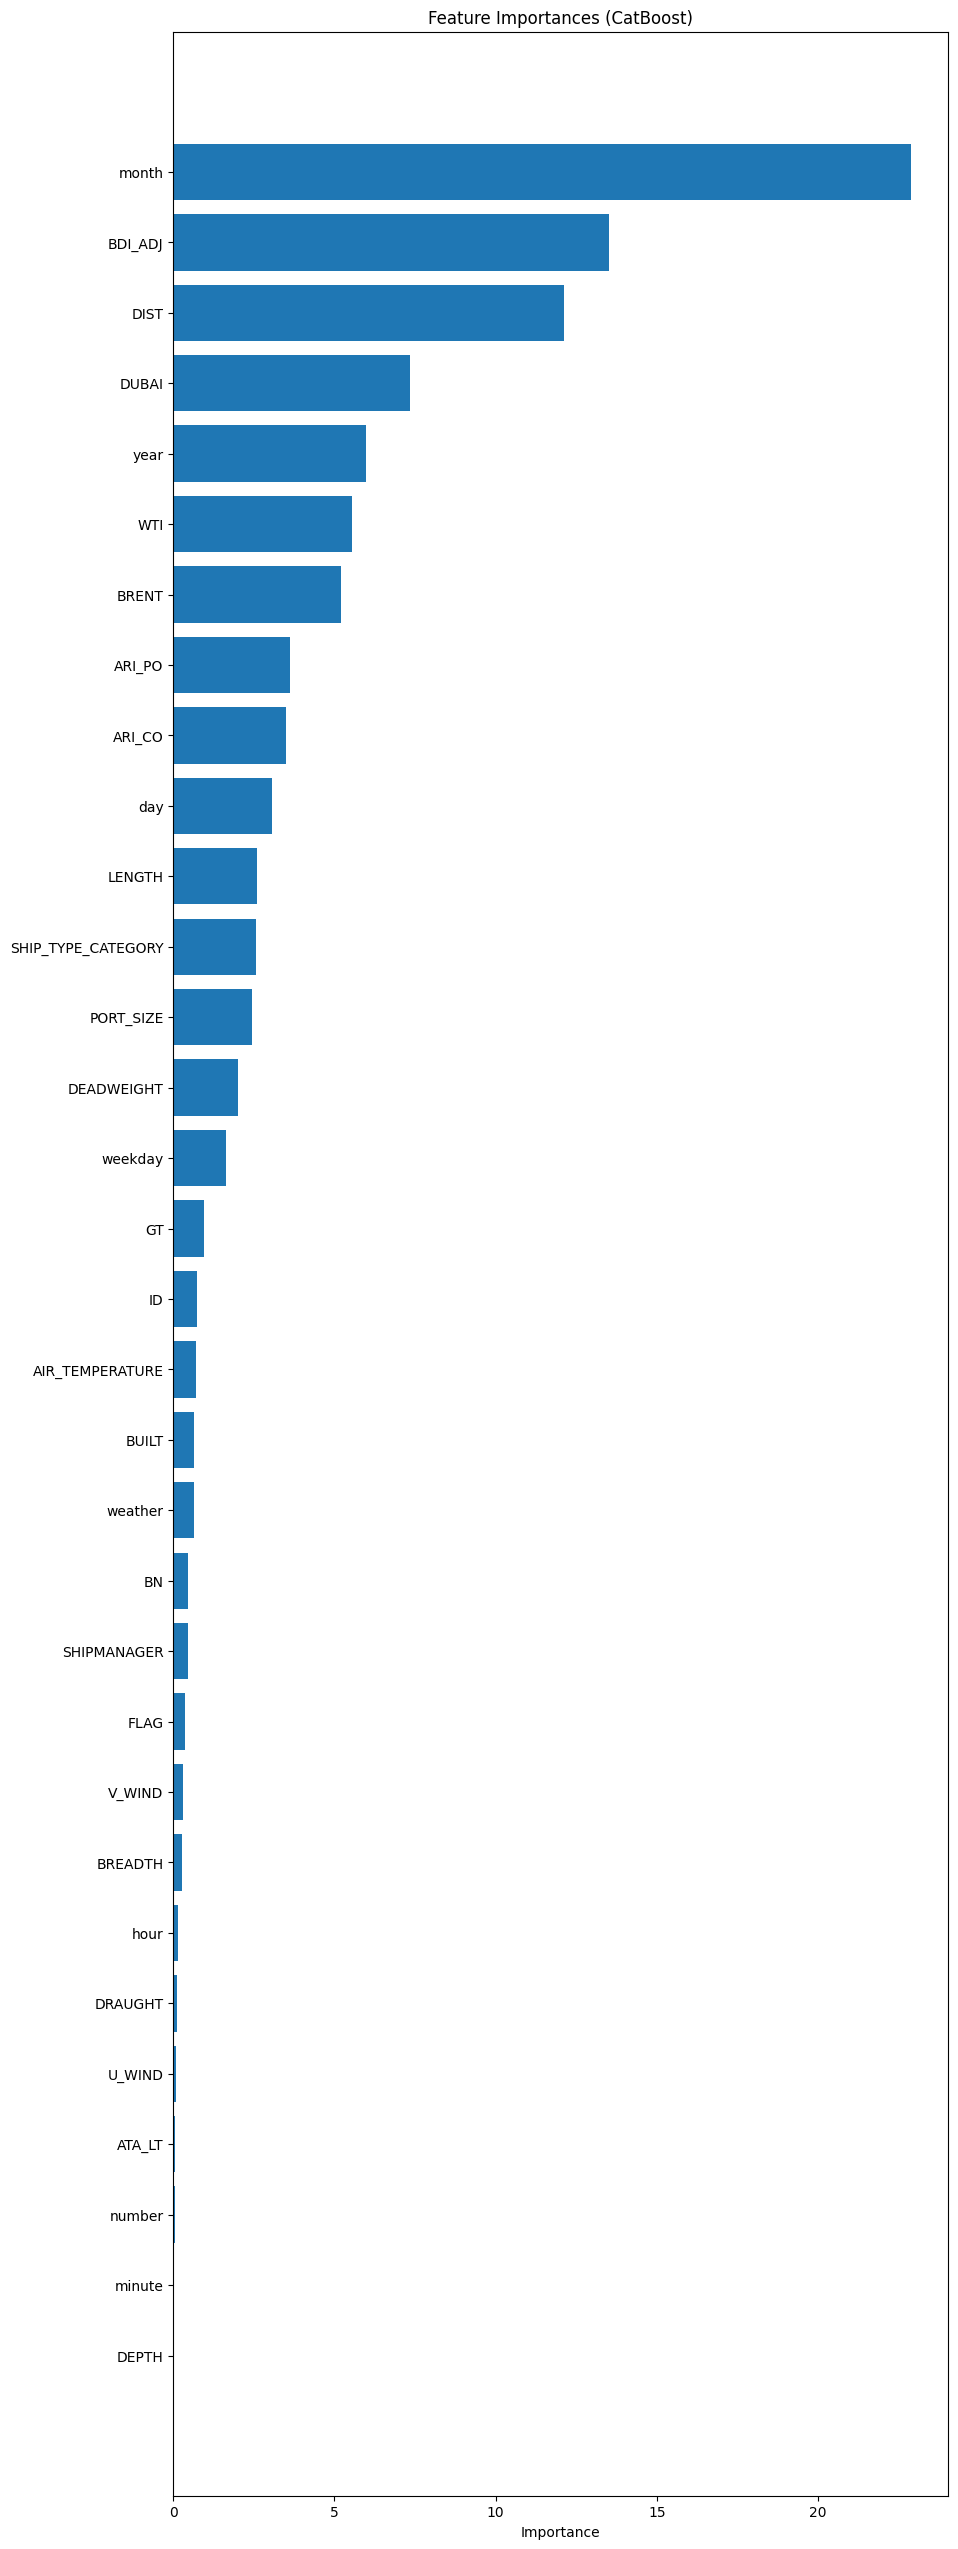

In [36]:
X_train = train_plus_one.drop(columns='CI_HOUR')
y_train = train_plus_one['CI_HOUR']

# 카테고리형 특성의 인덱스를 지정합니다.
cat_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG','weather']
# CatBoost 모델로 변경
catboost_model = CatBoostRegressor()
catboost_model, catboost_feature_importances = train_and_evaluate(catboost_model, 'CatBoost', X_train, y_train, cat_features)

## 특성 중요도로부터 Feature Selection

In [38]:
threshold = 1  # Your Threshold
low_importance_features = X_train.columns[catboost_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test_plus_one.drop(columns=low_importance_features)


## K-Fold Model Fitting & Validation

In [ ]:
X_t.head()

In [39]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
from tqdm import tqdm

# CatBoost 모델 초기화
catboost_model = CatBoostRegressor()

# 5-Fold 설정
# 10-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # CatBoost 모델 학습
    cat_features_idx = ['ARI_CO','ARI_PO','SHIP_TYPE_CATEGORY']
    catboost_model.fit(X_t, y_t, cat_features=cat_features_idx)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = catboost_model.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    catboost_pred = catboost_model.predict(X_test_reduced)
    catboost_pred = np.where(catboost_pred < 0, 0, catboost_pred)

    ensemble_predictions.append(catboost_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.102388
0:	learn: 170.7585472	total: 202ms	remaining: 3m 21s
1:	learn: 170.7571250	total: 372ms	remaining: 3m 5s
2:	learn: 170.7562361	total: 511ms	remaining: 2m 49s
3:	learn: 170.7545658	total: 736ms	remaining: 3m 3s
4:	learn: 170.7543568	total: 874ms	remaining: 2m 53s
5:	learn: 170.7527909	total: 1.05s	remaining: 2m 54s
6:	learn: 170.7513986	total: 1.2s	remaining: 2m 50s
7:	learn: 170.7501603	total: 1.45s	remaining: 2m 59s
8:	learn: 170.7479022	total: 1.62s	remaining: 2m 58s
9:	learn: 170.7462502	total: 1.78s	remaining: 2m 55s
10:	learn: 170.7451917	total: 1.93s	remaining: 2m 53s
11:	learn: 170.7436014	total: 2.09s	remaining: 2m 52s
12:	learn: 170.7429577	total: 2.23s	remaining: 2m 49s
13:	learn: 170.7405942	total: 2.4s	remaining: 2m 49s
14:	learn: 170.7403067	total: 2.54s	remaining: 2m 46s
15:	learn: 170.7392850	total: 2.69s	remaining: 2m 45s
16:	learn: 170.7389992	total: 2.78s	remaining: 2m 41s
17:	learn: 170.7377389	total: 2.9s	remaining: 2m 38s
18:	learn: 17

Processing folds:  20%|██        | 1/5 [03:31<14:06, 211.58s/it]

Learning rate set to 0.102388
0:	learn: 170.6802142	total: 100ms	remaining: 1m 40s
1:	learn: 170.6791509	total: 250ms	remaining: 2m 4s
2:	learn: 170.6776972	total: 427ms	remaining: 2m 21s
3:	learn: 170.6775608	total: 639ms	remaining: 2m 39s
4:	learn: 170.6755871	total: 814ms	remaining: 2m 41s
5:	learn: 170.6752769	total: 970ms	remaining: 2m 40s
6:	learn: 170.6748051	total: 1.15s	remaining: 2m 42s
7:	learn: 170.6745550	total: 1.3s	remaining: 2m 41s
8:	learn: 170.6700336	total: 1.54s	remaining: 2m 49s
9:	learn: 170.6696860	total: 1.67s	remaining: 2m 44s
10:	learn: 170.6696105	total: 1.8s	remaining: 2m 42s
11:	learn: 170.6695414	total: 1.92s	remaining: 2m 38s
12:	learn: 170.6693203	total: 2.05s	remaining: 2m 35s
13:	learn: 170.6690706	total: 2.24s	remaining: 2m 37s
14:	learn: 170.6674645	total: 2.4s	remaining: 2m 37s
15:	learn: 170.6670646	total: 2.52s	remaining: 2m 34s
16:	learn: 170.6667439	total: 2.69s	remaining: 2m 35s
17:	learn: 170.6667246	total: 2.79s	remaining: 2m 32s
18:	learn: 1

Processing folds:  40%|████      | 2/5 [06:54<10:19, 206.65s/it]

Learning rate set to 0.102388
0:	learn: 170.7394755	total: 180ms	remaining: 2m 59s
1:	learn: 170.7381147	total: 423ms	remaining: 3m 31s
2:	learn: 170.7379725	total: 695ms	remaining: 3m 51s
3:	learn: 170.7376488	total: 1.05s	remaining: 4m 21s
4:	learn: 170.7364648	total: 1.33s	remaining: 4m 24s
5:	learn: 170.7348561	total: 1.61s	remaining: 4m 26s
6:	learn: 170.7348342	total: 1.76s	remaining: 4m 10s
7:	learn: 170.7340985	total: 2.09s	remaining: 4m 19s
8:	learn: 170.7336619	total: 2.28s	remaining: 4m 10s
9:	learn: 170.7323611	total: 2.56s	remaining: 4m 13s
10:	learn: 170.7321814	total: 2.79s	remaining: 4m 10s
11:	learn: 170.7317751	total: 2.95s	remaining: 4m 2s
12:	learn: 170.7310724	total: 3.12s	remaining: 3m 56s
13:	learn: 170.7310692	total: 3.17s	remaining: 3m 43s
14:	learn: 170.7308670	total: 3.28s	remaining: 3m 35s
15:	learn: 170.7299095	total: 3.42s	remaining: 3m 30s
16:	learn: 170.7297998	total: 3.52s	remaining: 3m 23s
17:	learn: 170.7286065	total: 3.68s	remaining: 3m 20s
18:	learn

Processing folds:  60%|██████    | 3/5 [10:26<06:57, 209.00s/it]

Learning rate set to 0.102388
0:	learn: 169.9854174	total: 235ms	remaining: 3m 54s
1:	learn: 169.9850701	total: 406ms	remaining: 3m 22s
2:	learn: 169.9819398	total: 653ms	remaining: 3m 36s
3:	learn: 169.9819398	total: 697ms	remaining: 2m 53s
4:	learn: 169.9806369	total: 884ms	remaining: 2m 55s
5:	learn: 169.9805903	total: 996ms	remaining: 2m 44s
6:	learn: 169.9805432	total: 1.14s	remaining: 2m 41s
7:	learn: 169.9805067	total: 1.21s	remaining: 2m 29s
8:	learn: 169.9775399	total: 1.42s	remaining: 2m 36s
9:	learn: 169.9769887	total: 1.57s	remaining: 2m 35s
10:	learn: 169.9763655	total: 1.89s	remaining: 2m 49s
11:	learn: 169.9750872	total: 2.25s	remaining: 3m 5s
12:	learn: 169.9732946	total: 2.49s	remaining: 3m 9s
13:	learn: 169.9732139	total: 2.77s	remaining: 3m 14s
14:	learn: 169.9700221	total: 3.04s	remaining: 3m 19s
15:	learn: 169.9700126	total: 3.21s	remaining: 3m 17s
16:	learn: 169.9685927	total: 3.49s	remaining: 3m 21s
17:	learn: 169.9682013	total: 3.75s	remaining: 3m 24s
18:	learn:

Processing folds:  80%|████████  | 4/5 [13:59<03:30, 210.41s/it]

Learning rate set to 0.102388
0:	learn: 170.0146208	total: 216ms	remaining: 3m 35s
1:	learn: 170.0142651	total: 433ms	remaining: 3m 35s
2:	learn: 170.0138429	total: 605ms	remaining: 3m 21s
3:	learn: 170.0135862	total: 780ms	remaining: 3m 14s
4:	learn: 170.0132201	total: 927ms	remaining: 3m 4s
5:	learn: 170.0123761	total: 1.1s	remaining: 3m 1s
6:	learn: 170.0111022	total: 1.37s	remaining: 3m 14s
7:	learn: 170.0104779	total: 1.72s	remaining: 3m 33s
8:	learn: 170.0102101	total: 1.97s	remaining: 3m 36s
9:	learn: 170.0066613	total: 2.33s	remaining: 3m 50s
10:	learn: 170.0066042	total: 2.57s	remaining: 3m 50s
11:	learn: 170.0054513	total: 2.87s	remaining: 3m 56s
12:	learn: 170.0047730	total: 3.08s	remaining: 3m 54s
13:	learn: 170.0047577	total: 3.28s	remaining: 3m 51s
14:	learn: 170.0040780	total: 3.51s	remaining: 3m 50s
15:	learn: 170.0036542	total: 3.64s	remaining: 3m 44s
16:	learn: 170.0008488	total: 3.83s	remaining: 3m 41s
17:	learn: 170.0006712	total: 3.96s	remaining: 3m 36s
18:	learn: 

Processing folds: 100%|██████████| 5/5 [17:27<00:00, 209.74s/it]

Learning rate set to 0.102388
0:	learn: 170.8410166	total: 219ms	remaining: 3m 39s
1:	learn: 170.8405409	total: 391ms	remaining: 3m 15s
2:	learn: 170.8403927	total: 517ms	remaining: 2m 51s
3:	learn: 170.8403788	total: 627ms	remaining: 2m 36s
4:	learn: 170.8403767	total: 702ms	remaining: 2m 19s
5:	learn: 170.8397741	total: 865ms	remaining: 2m 23s
6:	learn: 170.8386379	total: 996ms	remaining: 2m 21s
7:	learn: 170.8382350	total: 1.19s	remaining: 2m 27s
8:	learn: 170.8377348	total: 1.32s	remaining: 2m 25s
9:	learn: 170.8340752	total: 1.51s	remaining: 2m 29s
10:	learn: 170.8331504	total: 1.69s	remaining: 2m 31s
11:	learn: 170.8326090	total: 1.85s	remaining: 2m 32s
12:	learn: 170.8311918	total: 1.99s	remaining: 2m 30s
13:	learn: 170.8308003	total: 2.15s	remaining: 2m 31s
14:	learn: 170.8303142	total: 2.29s	remaining: 2m 30s
15:	learn: 170.8291648	total: 2.46s	remaining: 2m 31s
16:	learn: 170.8276787	total: 2.62s	remaining: 2m 31s
17:	learn: 170.8257328	total: 2.77s	remaining: 2m 31s
18:	lear

Processing folds: 6it [20:51, 207.81s/it]                       

Learning rate set to 0.102388
0:	learn: 171.1654453	total: 251ms	remaining: 4m 10s
1:	learn: 171.1654326	total: 382ms	remaining: 3m 10s
2:	learn: 171.1634456	total: 588ms	remaining: 3m 15s
3:	learn: 171.1634005	total: 697ms	remaining: 2m 53s
4:	learn: 171.1614626	total: 1s	remaining: 3m 19s
5:	learn: 171.1597089	total: 1.25s	remaining: 3m 27s
6:	learn: 171.1559235	total: 1.49s	remaining: 3m 31s
7:	learn: 171.1558797	total: 1.69s	remaining: 3m 29s
8:	learn: 171.1557769	total: 2.01s	remaining: 3m 41s
9:	learn: 171.1541363	total: 2.26s	remaining: 3m 43s
10:	learn: 171.1538391	total: 2.5s	remaining: 3m 45s
11:	learn: 171.1512975	total: 2.82s	remaining: 3m 52s
12:	learn: 171.1510900	total: 3.15s	remaining: 3m 58s
13:	learn: 171.1509774	total: 3.25s	remaining: 3m 48s
14:	learn: 171.1509513	total: 3.38s	remaining: 3m 42s
15:	learn: 171.1477139	total: 3.54s	remaining: 3m 37s
16:	learn: 171.1475705	total: 3.73s	remaining: 3m 35s
17:	learn: 171.1467499	total: 3.89s	remaining: 3m 32s
18:	learn: 1

Processing folds: 7it [24:23, 209.14s/it]

Learning rate set to 0.102388
0:	learn: 170.3332039	total: 116ms	remaining: 1m 55s
1:	learn: 170.3287232	total: 366ms	remaining: 3m 2s
2:	learn: 170.3281334	total: 579ms	remaining: 3m 12s
3:	learn: 170.3277946	total: 676ms	remaining: 2m 48s
4:	learn: 170.3266418	total: 818ms	remaining: 2m 42s
5:	learn: 170.3247884	total: 979ms	remaining: 2m 42s
6:	learn: 170.3231989	total: 1.17s	remaining: 2m 46s
7:	learn: 170.3194442	total: 1.39s	remaining: 2m 51s
8:	learn: 170.3183995	total: 1.53s	remaining: 2m 48s
9:	learn: 170.3176638	total: 1.88s	remaining: 3m 5s
10:	learn: 170.3167662	total: 2.24s	remaining: 3m 21s
11:	learn: 170.3157466	total: 2.51s	remaining: 3m 26s
12:	learn: 170.3143575	total: 2.81s	remaining: 3m 33s
13:	learn: 170.3123236	total: 3.16s	remaining: 3m 42s
14:	learn: 170.3095152	total: 3.6s	remaining: 3m 56s
15:	learn: 170.3056650	total: 3.96s	remaining: 4m 3s
16:	learn: 170.3050050	total: 4.14s	remaining: 3m 59s
17:	learn: 170.3021509	total: 4.37s	remaining: 3m 58s
18:	learn: 1

Processing folds: 8it [27:55, 210.10s/it]

Learning rate set to 0.102388
0:	learn: 170.8981522	total: 249ms	remaining: 4m 8s
1:	learn: 170.8977419	total: 344ms	remaining: 2m 51s
2:	learn: 170.8966575	total: 534ms	remaining: 2m 57s
3:	learn: 170.8959641	total: 685ms	remaining: 2m 50s
4:	learn: 170.8895913	total: 951ms	remaining: 3m 9s
5:	learn: 170.8877365	total: 1.11s	remaining: 3m 4s
6:	learn: 170.8861504	total: 1.32s	remaining: 3m 7s
7:	learn: 170.8850406	total: 1.46s	remaining: 3m
8:	learn: 170.8839248	total: 1.6s	remaining: 2m 56s
9:	learn: 170.8802031	total: 1.87s	remaining: 3m 5s
10:	learn: 170.8754477	total: 2.27s	remaining: 3m 23s
11:	learn: 170.8728594	total: 2.63s	remaining: 3m 36s
12:	learn: 170.8708857	total: 2.84s	remaining: 3m 35s
13:	learn: 170.8695590	total: 3.17s	remaining: 3m 43s
14:	learn: 170.8687332	total: 3.45s	remaining: 3m 46s
15:	learn: 170.8677955	total: 3.8s	remaining: 3m 53s
16:	learn: 170.8655946	total: 4.17s	remaining: 4m 1s
17:	learn: 170.8604279	total: 4.46s	remaining: 4m 3s
18:	learn: 170.858334

Processing folds: 9it [31:28, 210.76s/it]

Learning rate set to 0.102388
0:	learn: 170.3121138	total: 251ms	remaining: 4m 10s
1:	learn: 170.3112210	total: 437ms	remaining: 3m 38s
2:	learn: 170.3101497	total: 608ms	remaining: 3m 22s
3:	learn: 170.3070611	total: 790ms	remaining: 3m 16s
4:	learn: 170.3060389	total: 928ms	remaining: 3m 4s
5:	learn: 170.3029794	total: 1.16s	remaining: 3m 12s
6:	learn: 170.3016078	total: 1.33s	remaining: 3m 9s
7:	learn: 170.3012872	total: 1.47s	remaining: 3m 2s
8:	learn: 170.3006383	total: 1.59s	remaining: 2m 55s
9:	learn: 170.2987913	total: 1.83s	remaining: 3m 1s
10:	learn: 170.2964106	total: 2s	remaining: 2m 59s
11:	learn: 170.2946747	total: 2.19s	remaining: 3m
12:	learn: 170.2935327	total: 2.33s	remaining: 2m 57s
13:	learn: 170.2933618	total: 2.42s	remaining: 2m 50s
14:	learn: 170.2921531	total: 2.56s	remaining: 2m 48s
15:	learn: 170.2920494	total: 2.67s	remaining: 2m 44s
16:	learn: 170.2905353	total: 2.91s	remaining: 2m 48s
17:	learn: 170.2899483	total: 3.17s	remaining: 2m 53s
18:	learn: 170.2895

Processing folds: 10it [34:57, 209.78s/it]

Validation : MAE scores for each fold: [79.87321431078406, 80.43018767445203, 80.40403974556779, 81.72591482517461, 82.05452673636599, 80.53168757125528, 79.52010126167254, 81.15082039375183, 79.66157185440576, 81.22579111301656]
Validation : MAE: 80.65778554864464


## Submission

In [40]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./catboost_submit10_10.csv', index=False)

In [ ]:
train